Chapter05
===
---

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings("ignore")

## 5.1. 重回帰
出席率データを用いる。
- A: アルバイトが好き(1) or 好きでない(0)
- Score: 学問への興味の強さ（200点満点）
- 1年間の出席率（総授業回数は200-500程度）

In [2]:
df = pd.read_csv("./input/data-attendance-1.txt")
df.tail()

,A,Score,Y
45,0,105,0.302
46,0,51,0.133
47,0,150,0.353
48,0,99,0.268
49,1,99,0.234


### 5.1.2. データの分布の確認
散布図行列を作成
本では上三角に相関係数が表示されたりカテゴリカル変数に対して箱ひげ図を描いたりしている

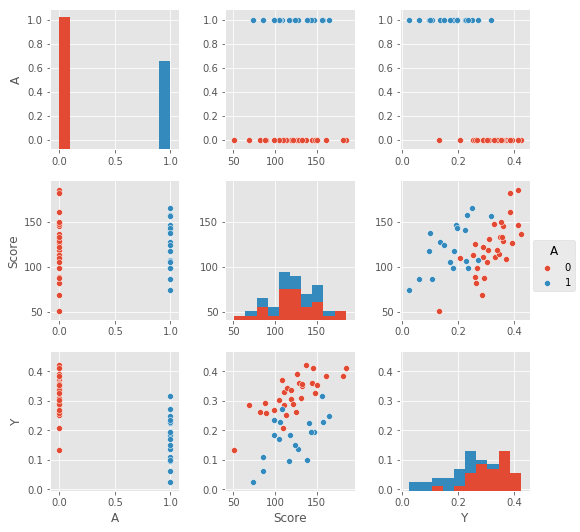

In [8]:
sns.pairplot(df, hue="A")

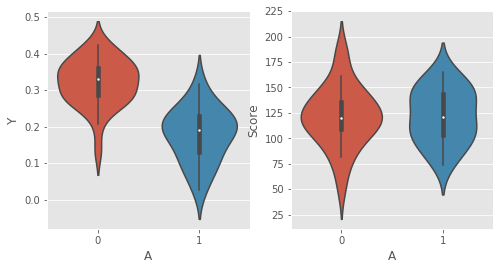

In [33]:
figsize(8, 4)
fig = plt.figure()
sns.violinplot(data=df, x="A", y="Y", ax=fig.add_subplot(1, 2, 1) )
sns.violinplot(data=df, x="A", y="Score", ax=fig.add_subplot(1, 2, 2) )

### 5.1.5. Stanで実装

In [34]:
!cat ./model/model5-3.stan

data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  real<lower=0, upper=1> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
  real<lower=0> sigma;
}

transformed parameters {
  real mu[N];
  for (n in 1:N)
    mu[n] = b1 + b2*A[n] + b3*Score[n];
}

model {
  for (n in 1:N)
    Y[n] ~ normal(mu[n], sigma);
}

generated quantities {
  // 予測分布。MCMCの各ステップで計算されるので、これもパラメータと同様に分布になる
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = normal_rng(mu[n], sigma);
}


In [36]:
# 0-1にnormalize
df_normalized = df.copy()
df_normalized.Score = df.Score / 200

# chap04では一歳おきに予測を出していたが、ここではN（学生数）それぞれの学生について出していることに注意
data = {
    **df_normalized.to_dict("list"),
    "N": len(df),
}

# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model5-3.stan")
# default設定でMCMCサンプリングを実行
fit = sm.sampling(data=data, seed=1234)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be4fede7a1d877d5ee1b7aa2c19644b4 NOW.


In [38]:
# samplingのiterationそれぞれごとにy_predなどをN個ずつsampleしているので長くなる
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_be4fede7a1d877d5ee1b7aa2c19644b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  8.5e-4   0.03   0.06    0.1   0.12   0.15   0.19   1538    1.0
b2          -0.14  3.0e-4   0.01  -0.17  -0.15  -0.14  -0.13  -0.11   2485    1.0
b3           0.32  1.3e-3   0.05   0.22   0.29   0.33   0.36   0.43   1533    1.0
sigma        0.05  1.2e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06   2085    1.0
mu[1]        0.24  4.1e-4   0.02    0.2   0.22   0.24   0.25   0.27   1724    1.0
mu[2]        0.21  2.8e-4   0.01   0.19   0.21   0.22   0.22   0.24   2195    1.0
mu[3]        0.33  1.7e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   3264    1.0
mu[4]        0.12  3.2e-4   0.01   0.09   0.11   0.12   0.13   0.15   2161    1.0
mu[5]        0.24  3.4e-4   0.02 

=> Rhatを見ると収束していそうなことがわかる

#### Trace plot

In [40]:
fit.extract(permuted=False, inc_warmup=True).shape

(2000, 4, 105)

In [42]:
def trace_plot(fit, params):
    """ StanModel.sampling()を実行して得られる結果のオブジェクトからMCMCのtrace plotを描画 """
    # shape (<# iter (including warmup)>, <# chain>, <# param + 1(lp__)>)
    mcmc_sample = fit.extract(permuted=False, inc_warmup=True)
    n_param = len(params)
    n_chain = mcmc_sample.shape[1]
    warmup = fit.sim["warmup"]

    fig, axes = plt.subplots(n_param, 2)
    for i_param in range(n_param):
        for i_chain in range(n_chain):
            # KDE plot (Posterioer istribution)
            axes[i_param, 0].set_title("{}: Distribution".format(params[i_param]))
            sns.kdeplot(mcmc_sample[:, i_chain, i_param], ax=axes[i_param, 0], label="chain {}".format(i_chain))
            axes[i_param, 0].legend(loc="upper right")

            # Trace plot (Chain)
            axes[i_param, 1].set_title("{}: Trace plot".format(params[i_param]))
            axes[i_param, 1].plot(mcmc_sample[:, i_chain, i_param], alpha=0.6, lw=0.5, label="chain {}".format(i_chain))
            axes[i_param, 1].vlines(warmup, mcmc_sample[:, :, i_param].min(), mcmc_sample[:, :, i_param].max(), linestyle="dashed", lw=1)
            axes[i_param, 1].legend(loc="upper right")

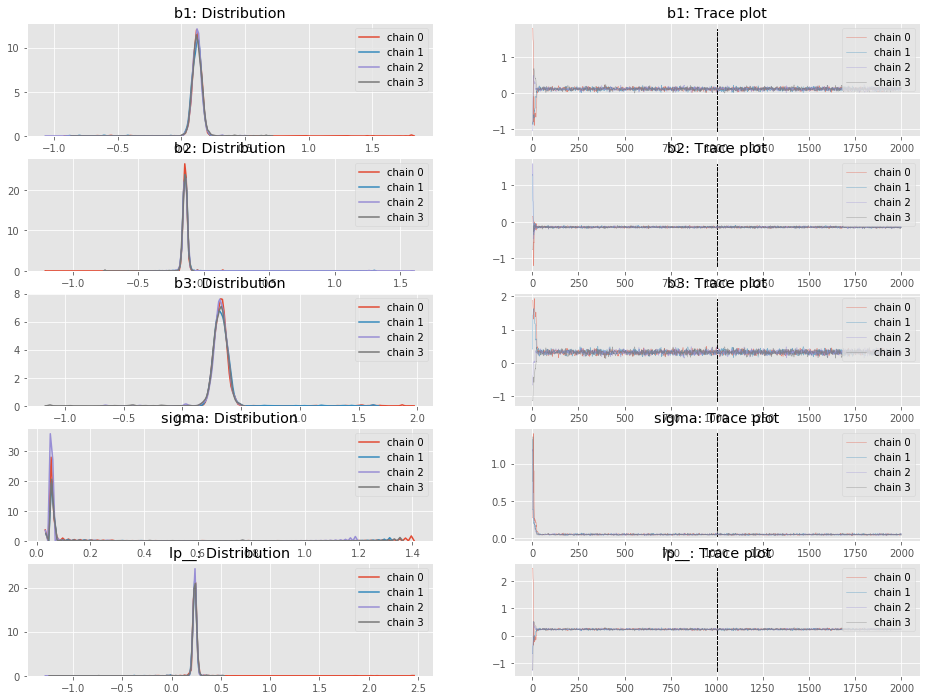

In [45]:
figsize(16, 12)
trace_plot(fit, ["b1", "b2", "b3", "sigma", "lp__"])

#### parameterの同時分布
chap04と同じようにplotしてみる

=> パラメータが多くなってくると散布図行列の方がbetter。あとで

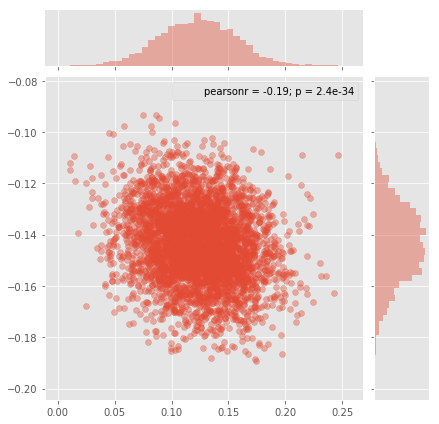

In [56]:
sns.jointplot(fit.extract()["b1"], fit.extract()["b2"], alpha=0.4)

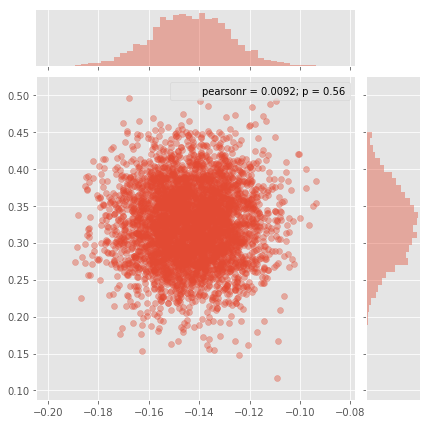

In [57]:
sns.jointplot(fit.extract()["b2"], fit.extract()["b3"], alpha=0.4)

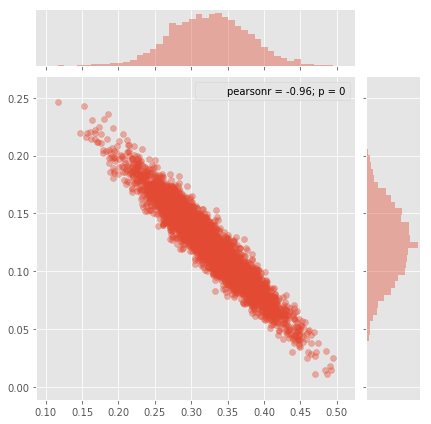

In [58]:
sns.jointplot(fit.extract()["b3"], fit.extract()["b1"], alpha=0.4)

#### 予測分布
今回は説明変数が質的変数1つ（A）、量的変数1つ（Score）のみなので二次元グラフの色分けで表現できる

が、上記のstanプログラムではScoreの値ごとに予想をsamplingしていないので省略する

#### 実測値と予測値のプロット
データの行（学生）ごとに、予測されるYと実際のYの関係をプロット

予測されるYは、sampleにおける中央値を代表値とする

In [115]:
df_normalized["mu"] = np.quantile(fit.extract()["mu"], [0.5], axis=0).ravel()

In [116]:
df_normalized["pred_lower"] = np.quantile(fit.extract()["y_pred"], [0.1], axis=0).ravel()
df_normalized["pred_upper"] = np.quantile(fit.extract()["y_pred"], [0.9], axis=0).ravel()
df_normalized.head()

,A,Score,Y,y_pred,mu,pred_lower,pred_upper
0,0,0.345,0.286,0.235689,0.235022,0.167275,0.305425
1,1,0.725,0.196,0.213956,0.215051,0.143591,0.282942
2,0,0.625,0.261,0.324624,0.326058,0.258782,0.392398
3,1,0.430,0.109,0.119065,0.119198,0.049541,0.187451
4,1,0.790,0.230,0.234130,0.236300,0.166648,0.304549


Text(0,0.5,'Predicted')

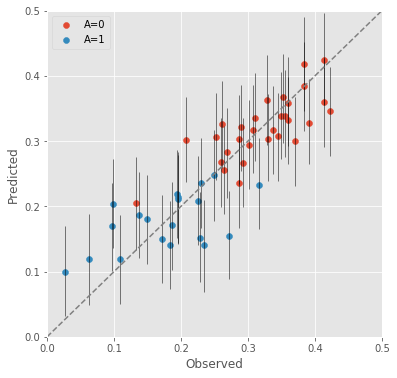

In [120]:
for _, r in df_normalized.iterrows():
    plt.vlines(r.Y, r.pred_lower, r.pred_upper, lw=0.5)

df_zero = df_normalized[df_normalized.A == 0]
df_one = df_normalized[df_normalized.A == 1]

plt.scatter(df_zero.Y, df_zero.mu ,label="A=0")
plt.scatter(df_one.Y, df_one.mu, label="A=1")

# y = x
x = np.linspace(0, 0.5, 10)
plt.plot(x, x, linestyle="dashed", c="gray")

plt.legend()
plt.xlim([0, 0.5])
plt.ylim(0, 0.5)
plt.xlabel("Observed")
plt.ylabel("Predicted")

=> 多くの80%区間がy=xを含んでおり、系統的なばらつきもなさそうなので、OKとする

#### ノイズの分布

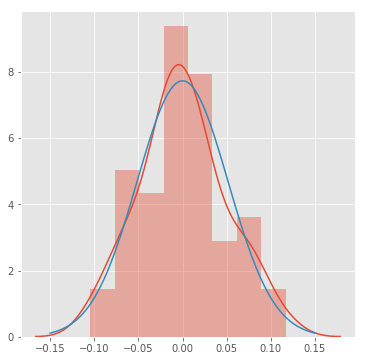

In [145]:
from scipy.stats import norm

# epsilonの分布
sns.distplot(df_normalized.Y - df_normalized.mu)

# sigmaの事後分布の中央値に基づく平均0の正規分布
x = np.linspace(-0.15, 0.15, 100)
plt.plot(x, norm.pdf(x, loc=0, scale=np.median(fit.extract()["sigma"])))

=> 乖離が少ないので良さそう

#### MCMCサンプルの散布図行列

In [151]:
df_posterior = pd.DataFrame()

for p in ["b1", "b2", "b3", "sigma", "lp__"]:
    df_posterior[p] = fit.extract()[p]
df_posterior.tail()

,b1,b2,b3,sigma,lp__
3995,0.132746,-0.120704,0.303282,0.047657,121.056183
3996,0.118784,-0.149878,0.287525,0.062932,114.644369
3997,0.155438,-0.140504,0.262300,0.049063,121.901103
3998,0.116244,-0.133255,0.332102,0.044892,122.105153
3999,0.142527,-0.173032,0.323684,0.054294,120.394927


In [156]:
df_posterior["mu0"] = fit.extract()["mu"][:, 0]
df_posterior["mu1"] = fit.extract()["mu"][:, 1]

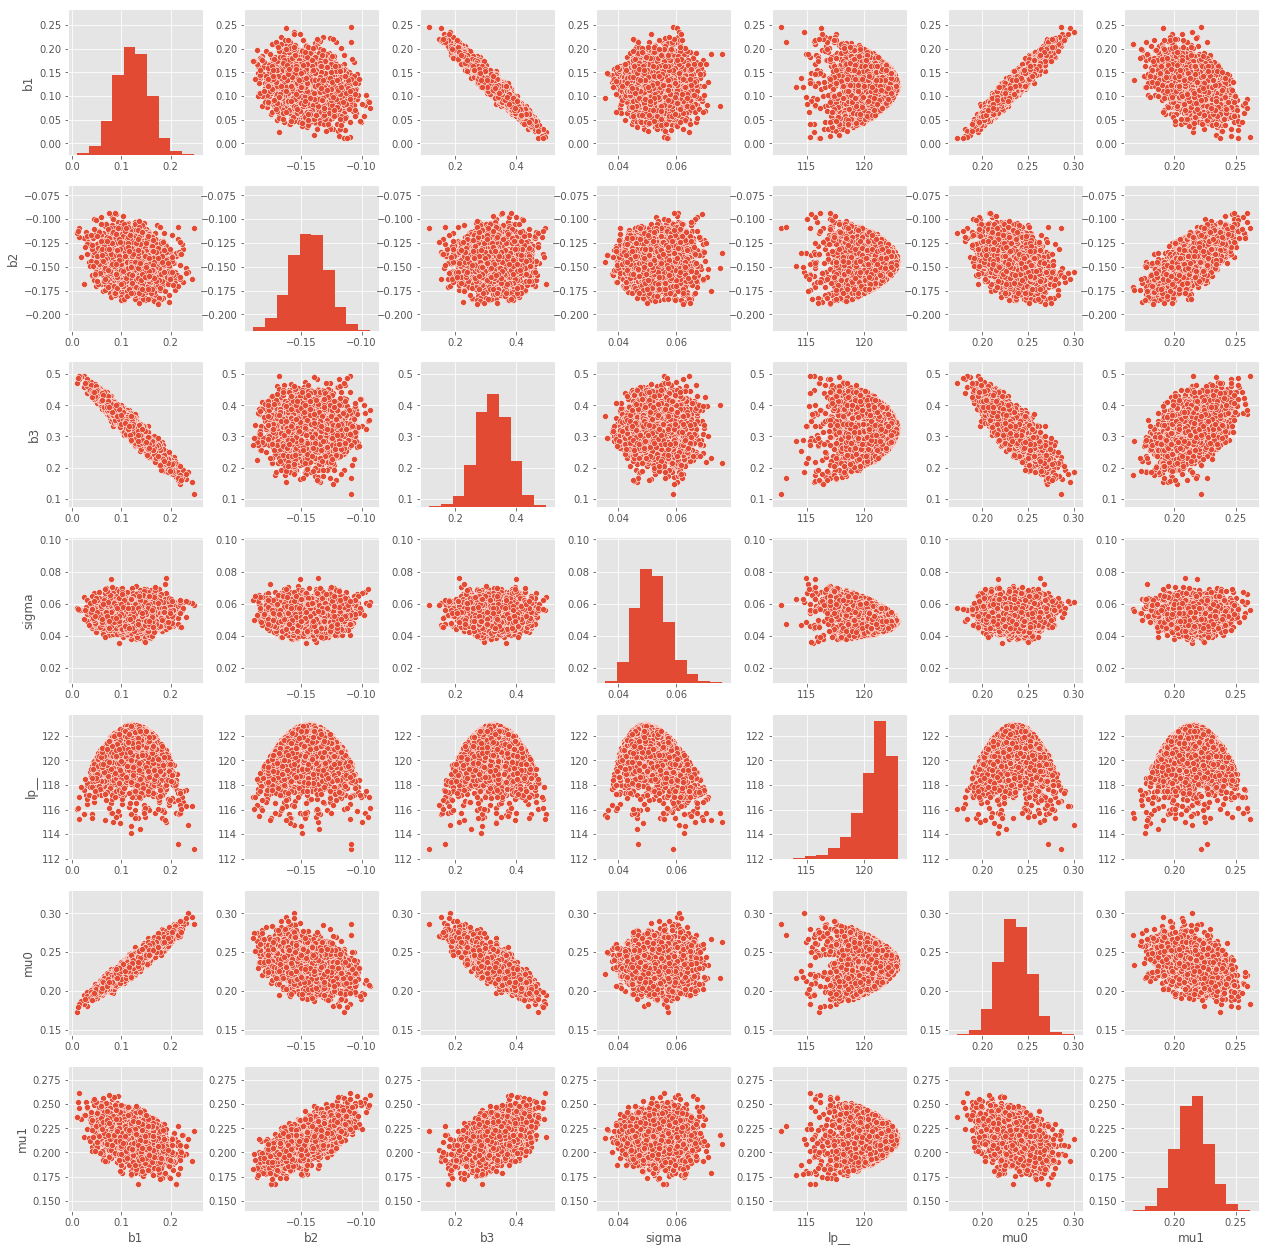

In [158]:
sns.pairplot(df_posterior)

## 5.2. 二項ロジスティック回帰
50人ぶんのデータ
- PersonID: ID
- A, Score: 同じ
- M: 3ヶ月間における履修登録した科目の総授業回数
- Y: そのうち実際に出席した回数

目的は、応答変数をMを固定した時のYとして、5.1.と同様にA, Scoreから予測すること。

ただし、**Y/Mを応答変数にはしない**。これは0-1に収まる必要があるが、回帰すると説明変数の組み合わせによってはその範囲を外れてナンセンスになる。sigmoidで0-1に変形したものを出席確率として説明変数の線型結合から予測し、その出席確率とMによる二項分布からYが生成されると考える。

In [178]:
df = pd.read_csv("./input/data-attendance-2.txt")
df.tail()

,PersonID,A,Score,M,Y
45,46,0,105,51,34
46,47,0,51,22,10
47,48,0,150,38,29
48,49,0,99,23,20
49,50,1,99,67,43


### 5.2.2. データの分布の確認

In [179]:
# 列を追加
df["ratio"] = df.Y / df.M
df.tail()

,PersonID,A,Score,M,Y,ratio
45,46,0,105,51,34,0.666667
46,47,0,51,22,10,0.454545
47,48,0,150,38,29,0.763158
48,49,0,99,23,20,0.869565
49,50,1,99,67,43,0.641791


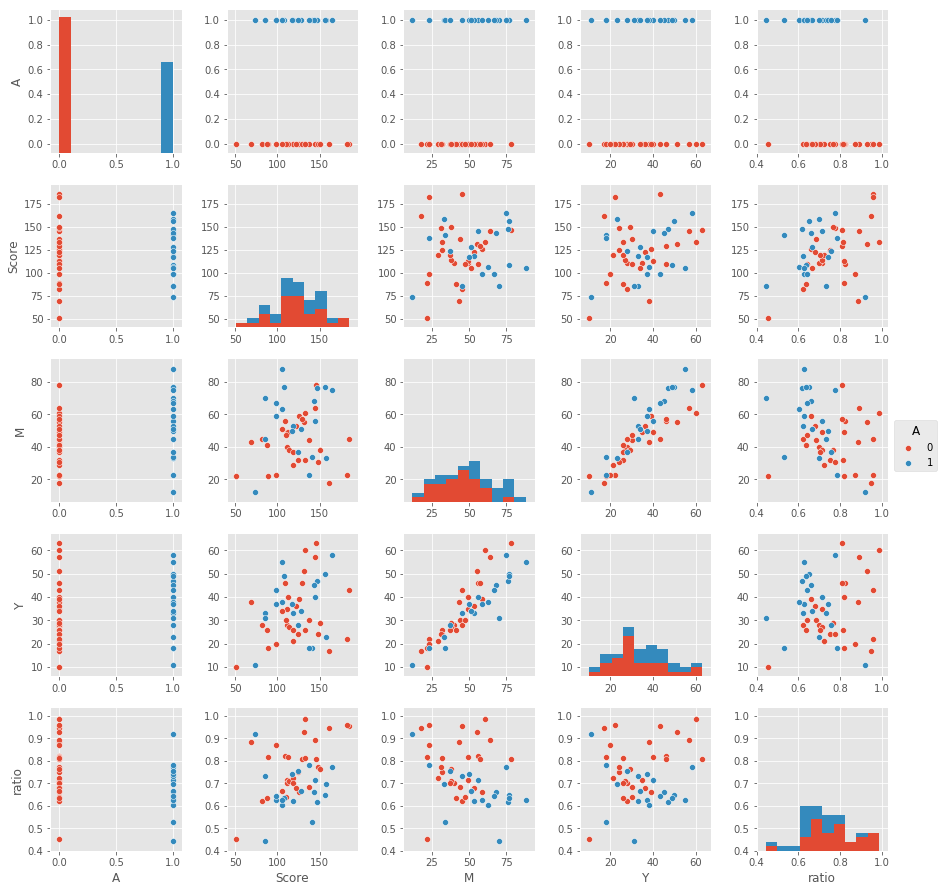

In [180]:
sns.pairplot(df[["A", "Score", "M", "Y", "ratio"]], hue="A")

### 5.2.5. Stanで実装

In [167]:
# N人の学生それぞれについての予測値もサンプルしていることに注意
!cat ./model/model5-4.stan

data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
  int<lower=0> Y[N];
}

parameters {
  real b1;
  real b2;
  real b3;
}

transformed parameters {
  real q[N];
  for (n in 1:N)
    q[n] = inv_logit(b1 + b2*A[n] + b3*Score[n]);
}

model {
  for (n in 1:N)
    Y[n] ~ binomial(M[n], q[n]);
}

generated quantities {
  real y_pred[N];
  for (n in 1:N)
    y_pred[n] = binomial_rng(M[n], q[n]);
}


In [181]:
# 実行
# 0-1にnormalize
df_normalized = df.copy()
df_normalized.Score = df.Score / 200

# PersonID, ratioはStanに渡さない
data = {
    **df_normalized.drop(["PersonID", "ratio"], axis=1).to_dict("list"),
    "N": len(df),
}

# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model5-4.stan")
# default設定でMCMCサンプリングを実行
fit = sm.sampling(data=data, seed=1234)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_004c106b40e5e7fb5b70c573034b1234 NOW.


In [182]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_004c106b40e5e7fb5b70c573034b1234.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  6.8e-3   0.24  -0.36  -0.07   0.08   0.24   0.58   1223    1.0
b2          -0.62  2.2e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.44   1821    1.0
b3           1.91    0.01   0.38   1.15   1.66    1.9   2.16   2.64   1274    1.0
q[1]         0.68  7.1e-4   0.03   0.63   0.66   0.68   0.69   0.73   1288    1.0
q[2]          0.7  3.8e-4   0.02   0.67   0.69    0.7   0.71   0.73   1880    1.0
q[3]         0.78  2.4e-4   0.01   0.76   0.77   0.78   0.79    0.8   2423    1.0
q[4]         0.57  5.2e-4   0.02   0.53   0.56   0.57   0.59   0.62   1860    1.0
q[5]         0.73  4.8e-4   0.02   0.69   0.71   0.73   0.74   0.76   1598    1.0
q[6]         0.79  2.3e-4   0.01 

### 5.2.7. 図によるモデルのチェック
Observed-Predictedの図を同様に描画

In [187]:
# samplingされた予測の80%区間と中央値をDataFrameに追加
df_normalized["pred"] = np.quantile(fit.extract()["y_pred"], [0.5], axis=0).ravel()
df_normalized["pred_upper"] = np.quantile(fit.extract()["y_pred"], [0.9], axis=0).ravel()
df_normalized["pred_lower"] = np.quantile(fit.extract()["y_pred"], [0.1], axis=0).ravel()

In [188]:
df_normalized.head()

,PersonID,A,Score,M,Y,ratio,pred,pred_upper,pred_lower
0,1,0,0.345,43,38,0.883721,29.0,33.0,25.0
1,2,1,0.725,56,40,0.714286,39.0,44.0,35.0
2,3,0,0.625,32,24,0.750000,25.0,28.0,22.0
3,4,1,0.430,45,33,0.733333,26.0,30.0,21.0
4,5,1,0.790,33,23,0.696970,24.0,27.0,21.0


In [193]:
df_normalized.M.max()

88

Text(0,0.5,'Predicted')

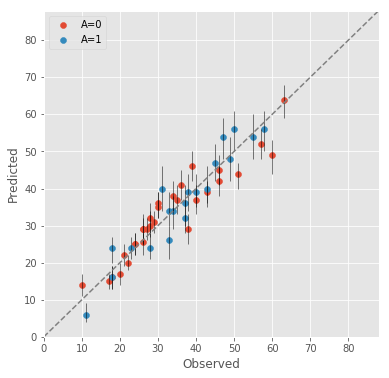

In [195]:
for _, r in df_normalized.iterrows():
    plt.vlines(r.Y, r.pred_lower, r.pred_upper, lw=0.5)

df_zero = df_normalized[df_normalized.A == 0]
df_one = df_normalized[df_normalized.A == 1]

plt.scatter(df_zero.Y, df_zero.pred ,label="A=0")
plt.scatter(df_one.Y, df_one.pred, label="A=1")

M_max = df_normalized.M.max()

# y = x
x = np.linspace(0, M_max, 10)
plt.plot(x, x, linestyle="dashed", c="gray")

plt.legend()
plt.xlim([0, M_max])
plt.ylim(0, M_max)
plt.xlabel("Observed")
plt.ylabel("Predicted")

## 5.3. ロジスティック回帰
授業日の天気が出席確率に影響を与えることが分かったので、集計前の出欠データを使って回帰を考える。
- Weather: A: 晴れ, B: 曇り, C: 雨
- Y: 授業に出席したかどうか（0: 欠席, 1: 出席）

学生の個人差は考慮せず、それぞれの出席を独立とみなしたモデルであることに注意

In [303]:
df = pd.read_csv("./input/data-attendance-3.txt")
df.tail()

,PersonID,A,Score,Weather,Y
2391,50,1,99,B,1
2392,50,1,99,A,1
2393,50,1,99,A,1
2394,50,1,99,C,1
2395,50,1,99,C,0


### 5.3.2. データの分布の確認
カテゴリカル変数が多いので散布図は書かない。

In [304]:
# 天気ごとのYの平均の違い
df.groupby("Weather").Y.agg("mean")

Weather
A    0.756950
B    0.684932
C    0.660934
Name: Y, dtype: float64

### 5.3.3. 背景知識を使った値の変換
ここでは、天気のA, B, Cをそれぞれ0, 0.2, 1に置き換える

In [305]:
d = {"A": 0, "B": 0.2, "C": 1}
df["W"] = df.Weather.map(lambda x: d[x])
df.head()

,PersonID,A,Score,Weather,Y,W
0,1,0,69,B,1,0.2
1,1,0,69,A,1,0.0
2,1,0,69,C,1,1.0
3,1,0,69,A,1,0.0
4,1,0,69,B,1,0.2


### 5.3.6. Stanで実装

In [306]:
# parameterを配列としていることに注意
!cat ./model/model5-5.stan

data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  // 配列にしている
  real b[4];
}

transformed parameters {
  real q[I];
  for (i in 1:I)
    q[i] = inv_logit(b[1] + b[2]*A[i] + b[3]*Score[i] + b[4]*W[i]);
}

model {
  for (i in 1:I)
    Y[i] ~ bernoulli(q[i]);
}


In [307]:
df.head()

,PersonID,A,Score,Weather,Y,W
0,1,0,69,B,1,0.2
1,1,0,69,A,1,0.0
2,1,0,69,C,1,1.0
3,1,0,69,A,1,0.0
4,1,0,69,B,1,0.2


In [308]:
# 実行
# 0-1にnormalize
df_normalized = df.copy()
df_normalized.Score = df.Score / 200

# PersonID, WeatherはStanに渡さない（Weatherは数値にしてWとして渡す）
data = {
    **df_normalized.drop(["PersonID", "Weather"], axis=1).to_dict("list"),
    "I": len(df),
}

# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model5-5.stan")
# default設定でMCMCサンプリングを実行
fit = sm.sampling(data=data, seed=1234)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_91284e0f0b7c0ef8a7dde8089b9d967d NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [309]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_91284e0f0b7c0ef8a7dde8089b9d967d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]    0.18  5.2e-3   0.23  -0.28   0.02   0.18   0.33   0.63   1985    1.0
b[2]   -0.62  1.7e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.44   2917    1.0
b[3]    1.95  8.1e-3   0.37   1.22    1.7   1.95    2.2   2.66   2101    1.0
b[4]   -0.46  2.3e-3   0.12   -0.7  -0.55  -0.46  -0.38  -0.22   3016    1.0
q[1]    0.68  5.5e-4   0.02   0.63   0.66   0.68    0.7   0.73   2080    1.0
q[2]     0.7  5.4e-4   0.02   0.65   0.68    0.7   0.72   0.75   2077    1.0
q[3]     0.6  7.1e-4   0.04   0.52   0.57    0.6   0.62   0.67   2588    1.0
q[4]     0.7  5.4e-4   0.02   0.65   0.68    0.7   0.72   0.75   2077    1.0
q[5]    0.68  5.5e-4   0.02   0.63   0.66   0.68    0.7   0.73   2080    1.0
q

### 5.3.7. 図によるモデルのチェック
A=0かつWeather=A（アルバイトが好きでなく天気が晴れ）に限定して、データの応答変数Yとqの信頼区間を描画

In [310]:
# q（予測された出席確率）の中央値と80%信頼区間をdfに追加
df["q_median"] = np.quantile(fit.extract()["q"], [0.5], axis=0).ravel()
df["q_lower"] = np.quantile(fit.extract()["q"], [0.1], axis=0).ravel()
df["q_upper"] = np.quantile(fit.extract()["q"], [0.9], axis=0).ravel()
df.head()

,PersonID,A,Score,Weather,Y,W,q_median,q_lower,q_upper
0,1,0,69,B,1,0.2,0.680616,0.647429,0.711948
1,1,0,69,A,1,0.0,0.700299,0.667528,0.731665
2,1,0,69,C,1,1.0,0.596334,0.547908,0.640723
3,1,0,69,A,1,0.0,0.700299,0.667528,0.731665
4,1,0,69,B,1,0.2,0.680616,0.647429,0.711948


In [311]:
# A=0, Weather=Aに限定
df2 = df[(df.A==0)&(df.Weather=="A")]
print(df2.shape)
df2.tail()

(674, 9)


,PersonID,A,Score,Weather,Y,W,q_median,q_lower,q_upper
2320,49,0,99,A,1,0.0,0.758008,0.738344,0.776825
2322,49,0,99,A,1,0.0,0.758008,0.738344,0.776825
2323,49,0,99,A,1,0.0,0.758008,0.738344,0.776825
2325,49,0,99,A,1,0.0,0.758008,0.738344,0.776825
2328,49,0,99,A,1,0.0,0.758008,0.738344,0.776825


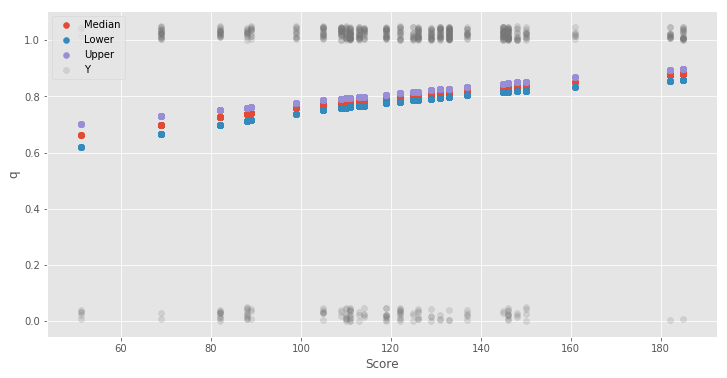

In [312]:
#Scoreごとに予測を出すのは面倒なので、データごとにして妥協
figsize(12, 6)
plt.figure()
plt.scatter(df2.Score, df2.q_median, label="Median")
plt.scatter(df2.Score, df2.q_lower, label="Lower")
plt.scatter(df2.Score, df2.q_upper, label="Upper")

plt.scatter(df2.Score, df2.Y+np.random.rand(len(df2))*0.05, alpha=0.2)

#plt.title("Y_base")
plt.xlabel("Score")
plt.ylabel("q")
plt.legend(loc='upper left')

#### 確率と実測値のプロット

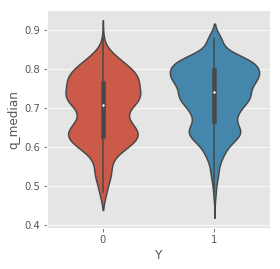

In [313]:
figsize(4, 4)
sns.violinplot(data=df, x="Y", y="q_median")

=> 十分には予測できていない

#### ROC曲線

Text(0,0.5,'True Positive')

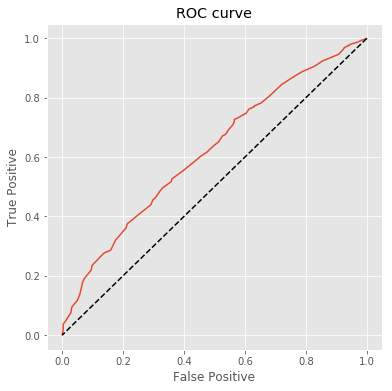

In [322]:
figsize(6, 6)

d = df.copy()

fp_list = []
tp_list = []

for thresh in np.linspace(df.q_median.min(), df.q_median.max(), 100):
    d["Y_pred"] = d.q_median.map(lambda x: int(x>thresh))
    fp = len(d[(d.Y==0) & (d.Y_pred==1)]) / len(d[d.Y == 0])
    tp = len(d[(d.Y==1) & (d.Y_pred==1)]) / len(d[d.Y == 1])
    fp_list.append(fp)
    tp_list.append(tp)

# ROC curve
plt.plot(fp_list, tp_list)
plt.plot(fp_list, fp_list, linestyle="dashed", color="black")
plt.title("ROC curve")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

## 5.4. ポアソン回帰
5.2. と同じデータを扱うが、ここでは説明変数A, Scoreがそう授業回数Mにどれほど影響しているかを知りたいとする。履修登録に対する積極性を説明変数に帰するイメージ。

Mは計数なのでポアソン分布に従うとし、その平均（>0）が説明変数の線型結合のexpになるというモデルを考える。

In [284]:
df = pd.read_csv("./input/data-attendance-2.txt")
df.tail()

,PersonID,A,Score,M,Y
45,46,0,105,51,34
46,47,0,51,22,10
47,48,0,150,38,29
48,49,0,99,23,20
49,50,1,99,67,43


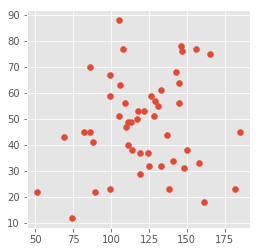

In [287]:
plt.scatter(df.Score, df.M)

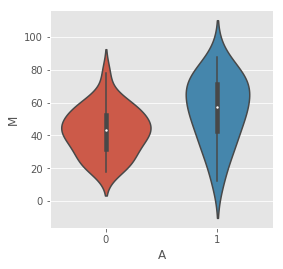

In [289]:
sns.violinplot(data=df, x="A", y="M")

### 5.4.3. Stanで実装

In [291]:
# N, A, Score, Mをデータとして渡す
# 予測をm_predとしてポアソン分布からサンプリングしている
!cat ./model/model5-6.stan

data {
  int N;
  int<lower=0, upper=1> A[N];
  real<lower=0, upper=1> Score[N];
  int<lower=0> M[N];
}

parameters {
  real b[3];
}

transformed parameters {
  real lambda[N];
  for (n in 1:N)
    lambda[n] = exp(b[1] + b[2]*A[n] + b[3]*Score[n]);
}

model {
  for (n in 1:N)
    M[n] ~ poisson(lambda[n]);
}

generated quantities {
  int m_pred[N];
  for (n in 1:N)
    m_pred[n] = poisson_rng(lambda[n]);
}


In [292]:
df.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


In [293]:
# 実行
# 0-1にnormalize
df_normalized = df.copy()
df_normalized.Score = df.Score / 200


data = {
    **df_normalized.drop(["PersonID", "Y"], axis=1).to_dict("list"),
    "N": len(df),
}

# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model5-6.stan")
# default設定でMCMCサンプリングを実行
fit = sm.sampling(data=data, seed=1234)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e04878643b158a426ab5161cf10a048a NOW.


In [294]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_e04878643b158a426ab5161cf10a048a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]         3.58  2.8e-3    0.1   3.39   3.51   3.57   3.64   3.77   1158    1.0
b[2]         0.26  9.4e-4   0.04   0.18   0.24   0.26   0.29   0.34   1883    1.0
b[3]         0.29  4.3e-3   0.15  -0.01    0.2    0.3   0.39   0.58   1177    1.0
lambda[1]    39.6    0.05   1.94  35.91  38.28  39.53  40.87  43.55   1274    1.0
lambda[2]   57.54    0.04   1.97  53.79  56.23  57.52  58.81  61.48   2192    1.0
lambda[3]   42.95    0.02   1.19  40.67  42.12  42.95  43.76  45.32   2816    1.0
lambda[4]   52.79    0.06   2.17  48.67  51.31  52.75  54.21  57.13   1554    1.0
lambda[5]   58.66    0.05   2.32   54.2  57.07  58.65   60.2  63.35   1866    1.0
lambda[6]   43.46    0.02   1.25 

=> bの値から、予測される出席回数が説明変数によって何倍になるかを解釈できる